In [24]:
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Autó-regresszív modellek

Az autó-regresszív generálási folyamat lassú, hiszen tokenenként prediktál a modell. Minden új predikció függ az előző kontextustól. Ahhoz, hogy az 1000. tokent kiszámítsuk, a modellnek szüksége van információra az előző 999 tokenről. Ahhoz, hogy az 1001. tokent kiszámítsuk, a modellnek ismét szüksége van információra az első 999 tokenről, viszont az egyetlen új művelet ezekben az 1000. tokennel való műveletek, az összes többi ismétlődik.

A kulcs-érték (key-value, KV) vektorokat használjuk a figyelmi értékek kiszámításához, és a KV cache (gyorsítótár) megszünteti ezt a hatékonyságcsökkenést olyan módon, hogy tárolja a korábban feldolgozott tokenek figyelemrétegeiből származó kulcs-érték párokat.

Megjegyzés. A gyorsítótárazás csak következtetési idő alatt használandó, tanítás alatt nem.

# Figyelmi mátrixok

A skálázott skalár-szorzat alapú figyelmi mérték az alábbi képlet alapján számolódik ki, ahol $T$ (eddigi) szekvenciahosszhoz, és $d_{\text{h}}$ a figyelemfejek dimenziója, $b$
a batchek mérete, $h$ a figyelemfejek száma.

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^\top}{\sqrt{d_{\text{h}}}} \times \text{mask} \right) V
$$

A lekérdezési (query, $Q$), kulcs (key, $K$) és érték (value, $V$) mátrixok a $(b, h, T, d_{\text{h}})$ alakú bemeneti beágyazásokból származó vetületek.

Az ok-okozati figyelem esetében a maszk megakadályozza, hogy a modell a jövőbeli tokenekre figyeljen. Miután egy token feldolgozásra került, annak reprezentációja a jövőbeli tokenek tekintetében soha nem változik, ami azt jelenti, hogy a $K_{\text{past}}$ és a $V_{\text{past}}$ gyorsítótárba helyezhető és újra felhasználható az utolsó token reprezentációjának kiszámításához.

$$
K_{\text{cache}} \leftarrow \text{concat}(K_{\text{past}}, k_t), \quad V_{\text{cache}} \leftarrow \text{concat}(V_{\text{past}}, v_t)
$$

Megjegyzés. A figyelem a modell minden rétegében függetlenül kerül kiszámításra, és a gyorsítótárazás rétegenként történik.

In [26]:
class MinimalSelfAttention(nn.Module):

    def __init__(self, d_model: int, head_dim: int) -> None:
        super().__init__()
        self.head_dim = head_dim
        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(
        self,
        x: torch.Tensor,
        kv_cache: tuple[torch.Tensor, torch.Tensor] | None = None
    ) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        _, seq_len, _ = x.shape

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            k = torch.cat([k_past, k], dim=1)
            v = torch.cat([v_past, v], dim=1)

        current_cache = (k, v)

        scores = (q @ k.transpose(1, 2)) / (self.head_dim**0.5)

        if seq_len > 1:
            mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device))
            scores = scores.masked_fill(mask == 0, -torch.inf)

        attn = F.softmax(scores, dim=-1)
        context = attn @ v

        return self.o_proj(context), current_cache


# Számítási igény

Így a számítási igény $O(T^2)$-ről $O(T)$-re (lépésenként $O(1)$-re) csökken.

In [27]:
d_model = 512
head_dim = 64
prompt_len = 100
gen_steps = 200

model = MinimalSelfAttention(d_model, head_dim=64).to(device)
prompt = torch.randn(1, prompt_len, d_model).to(device)

naive_times = []
curr_input = prompt.clone()
start_total = time.time()

for i in range(gen_steps):
    step_start = time.time()
    _ = model(curr_input, kv_cache=None)

    next_tok = torch.randn(1, 1, d_model).to(device)
    curr_input = torch.cat([curr_input, next_tok], dim=1)

    naive_times.append(time.time() - start_total)

cached_times = []

curr_input_c = prompt.clone()
_, cache = model(curr_input_c, kv_cache=None)

next_tok = torch.randn(1, 1, d_model).to(device)
start_total = time.time()

for i in range(gen_steps):
    step_start = time.time()
    _, cache = model(next_tok, kv_cache=cache)

    next_tok = torch.randn(1, 1, d_model).to(device)
    cached_times.append(time.time() - start_total)


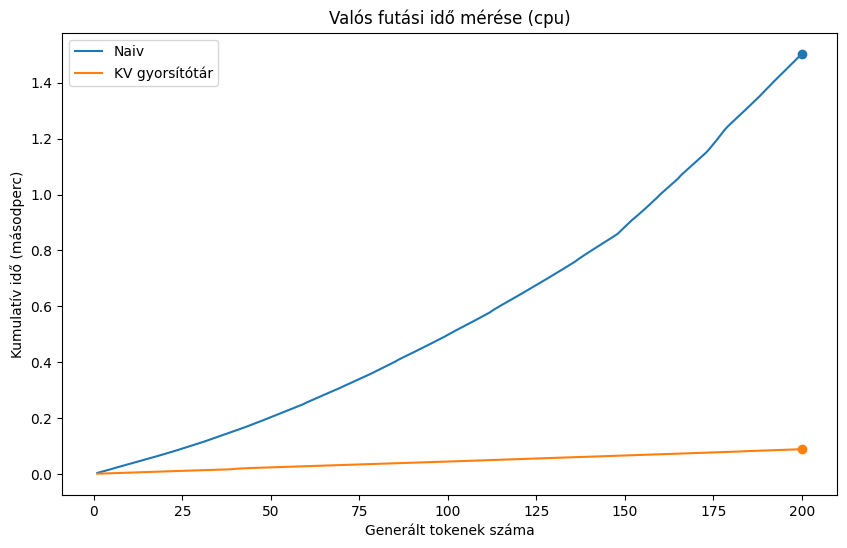

In [28]:
x_axis = np.arange(1, gen_steps + 1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_axis, naive_times, label='Naiv')
ax.plot(x_axis, cached_times, label='KV gyorsítótár')


ax.set_title(f'Valós futási idő mérése ({device})')
ax.set_xlabel('Generált tokenek száma')
ax.set_ylabel('Kumulatív idő (másodperc)')

ax.scatter(gen_steps, naive_times[-1])
ax.scatter(gen_steps, cached_times[-1])

plt.legend()
plt.show()

# Matematikai determinizmus

Egy $t$ pozícióban lévő token ($x_t$) reprezentációjának kiszámításakor a modell szigorúan csak az $x_1, \dots, x_t$ tokeneket "láthatja" (lásd, kauzális maszk). A jövőbeli $x_{t+1}$ token generálása vagy jelenléte semmilyen módon nem befolyásolja visszamenőleg az $x_t$ reprezentációját.

Tekintsük a kulcs ($k_t$) kiszámítását:

$$
k_t = x_t W_K
$$

ahol:

- $x_t$ a $t$-edik bemeneti token beágyazása (konstans),
- $W_K$ a súlymátrix (inferencia alatt fagyasztott, konstans).

Mivel a bemenet a múltban konstans, és a súlyok is konstansok, ezért a $k_t$ és a $v_t$ vektorok determinisztikusak és időben invariánsak.

Megjegyzés. Ez "Decoder-only" modellekre igaz csak. Az "Encoder" típusú modelleknél, ahol a figyelem kétirányú, a jövőbeli szavak megváltoztatják a múltbeli szavak kontextusát, így ott a KV gyorsítótár nem alkalmazható.

# Kompromisszum

Bár a KV gyorsítótár drasztikusan csökkenti a számítási időt, ennek ára a megnövekedett memóriaigény. A gyorsítótár mérete lineárisan nő a szekvencia hosszával és a batch méretével.

Egyetlen réteg gyorsítótárának mérete:

$$
N_{\text{elem}} = 2 \times b \times T \times h \times d_{\text{h}}
$$

Ahol a $2$-es szorzó a $K$ és $V$ mátrixokat jelöli. Hosszú kontextusú modelleknél ez a gyorsítótár akár több tíz gigabájt memóriát is felemészthet.

Megjegyzés. A számításhoz fizikailag mindig szükség van a $K$ és $V$ vektorokra, viszont a naív módszernél ez átmeneti memória, míg a KV gyorsítótár idejében tartós, ami folyamatosan foglalja a VRAM-ot, csökkentve ezzel a párhuzamosan kiszolgálható felhasználók számát.